In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
data = pd.read_csv('./btc.csv')

# Display the first few rows of the dataset
data.head()

,Date,Open,High,Low,Close,Volume
0,2010-07-18,0.0,0.1,0.1,0.1,80.0
1,2010-07-19,0.1,0.1,0.1,0.1,570.0
2,2010-07-20,0.1,0.1,0.1,0.1,260.0
3,2010-07-21,0.1,0.1,0.1,0.1,580.0
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0


In [2]:
missing_values = data.isnull().sum()
print(missing_values)

Date      0
Open      0
High      0
Low       0
Close     0
Volume    6
dtype: int64


Phân tích phân phối của các cột 

Summary Statistics:
                Open          High           Low         Close        Volume
count   4994.000000   4994.000000   4994.000000   4994.000000  4.988000e+03
mean   10754.806948  11007.469644  10485.664638  10766.334381  1.179480e+10
std    15798.109822  16176.285768  15385.079733  15811.764818  1.785750e+10
min        0.000000      0.100000      0.000000      0.100000  8.000000e+01
25%      226.600000    231.200000    222.400000    226.900000  5.895000e+04
50%     1871.600000   1954.500000   1825.050000   1909.250000  8.604240e+08
75%    15285.850000  15834.225000  14329.425000  15321.950000  2.049945e+10
max    73079.400000  73750.100000  71334.100000  73083.500000  3.509679e+11


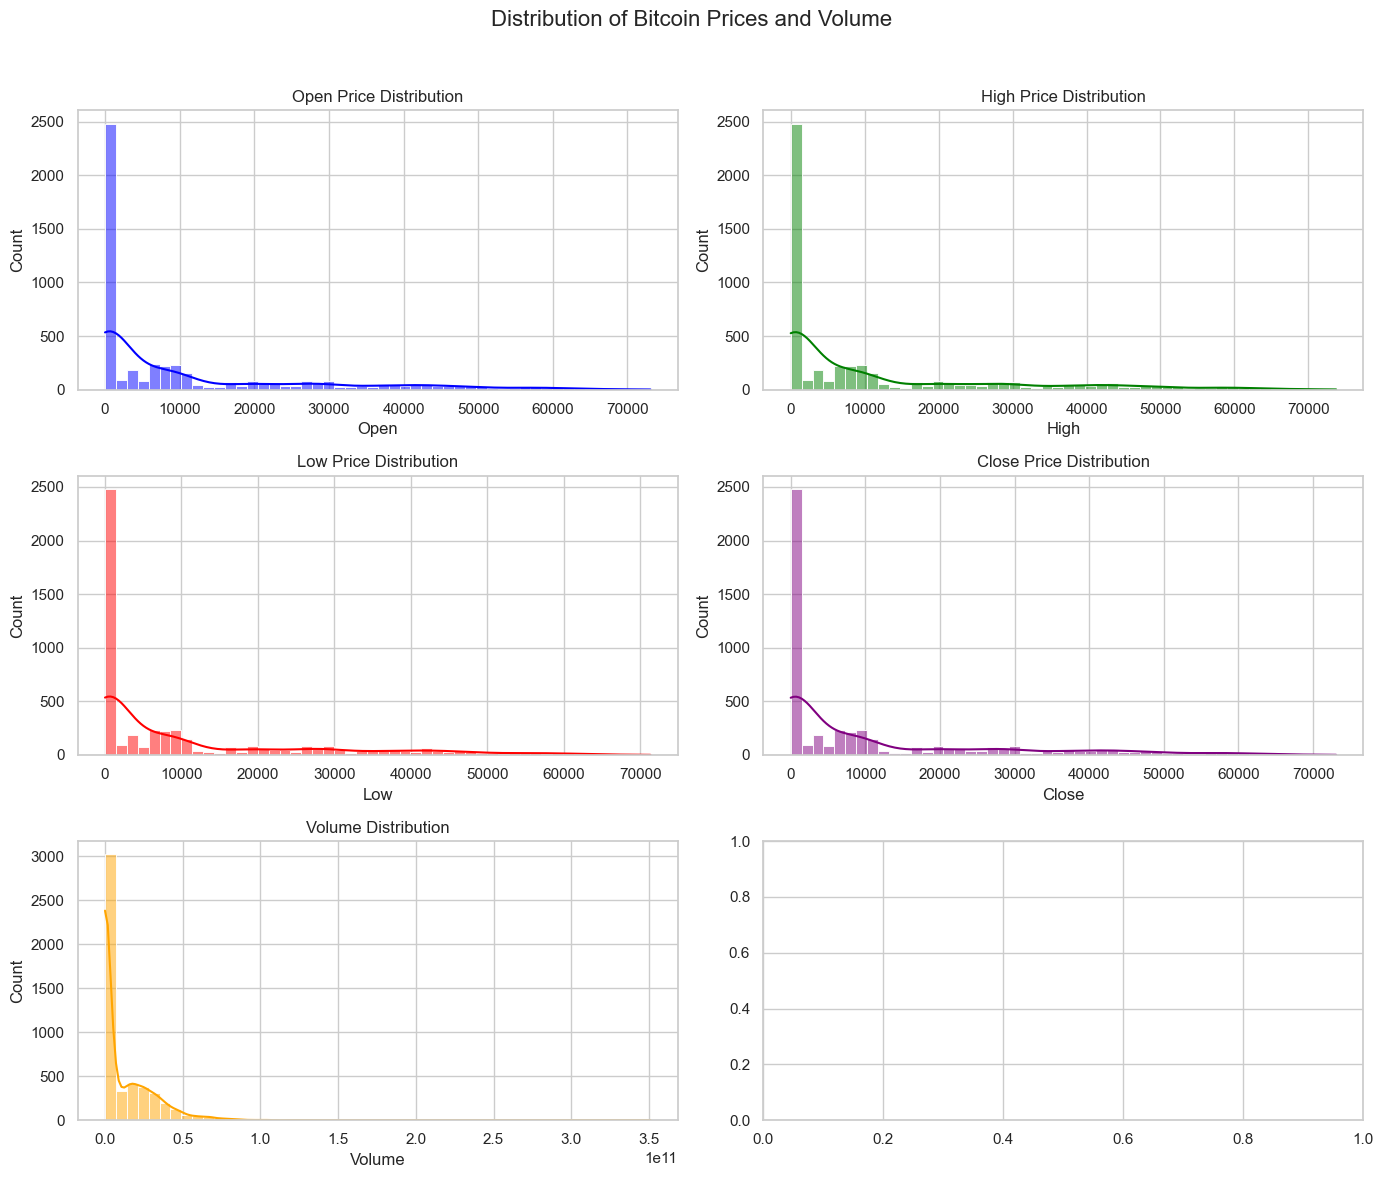

In [3]:
sns.set(style="whitegrid")

# Select only numerical columns for distribution analysis
numerical_data = data.select_dtypes(include=[np.number])

# Summary statistics for numerical columns
print("Summary Statistics:\n", numerical_data.describe())

# Histograms for distribution of each numerical column
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
fig.suptitle('Distribution of Bitcoin Prices and Volume', fontsize=16)

sns.histplot(data=numerical_data, x='Open', bins=50, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Open Price Distribution')

sns.histplot(data=numerical_data, x='High', bins=50, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('High Price Distribution')

sns.histplot(data=numerical_data, x='Low', bins=50, kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Low Price Distribution')

sns.histplot(data=numerical_data, x='Close', bins=50, kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Close Price Distribution')

sns.histplot(data=numerical_data, x='Volume', bins=50, kde=True, ax=axes[2, 0], color='orange')
axes[2, 0].set_title('Volume Distribution')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Xu hướng giá chung của bitcoin

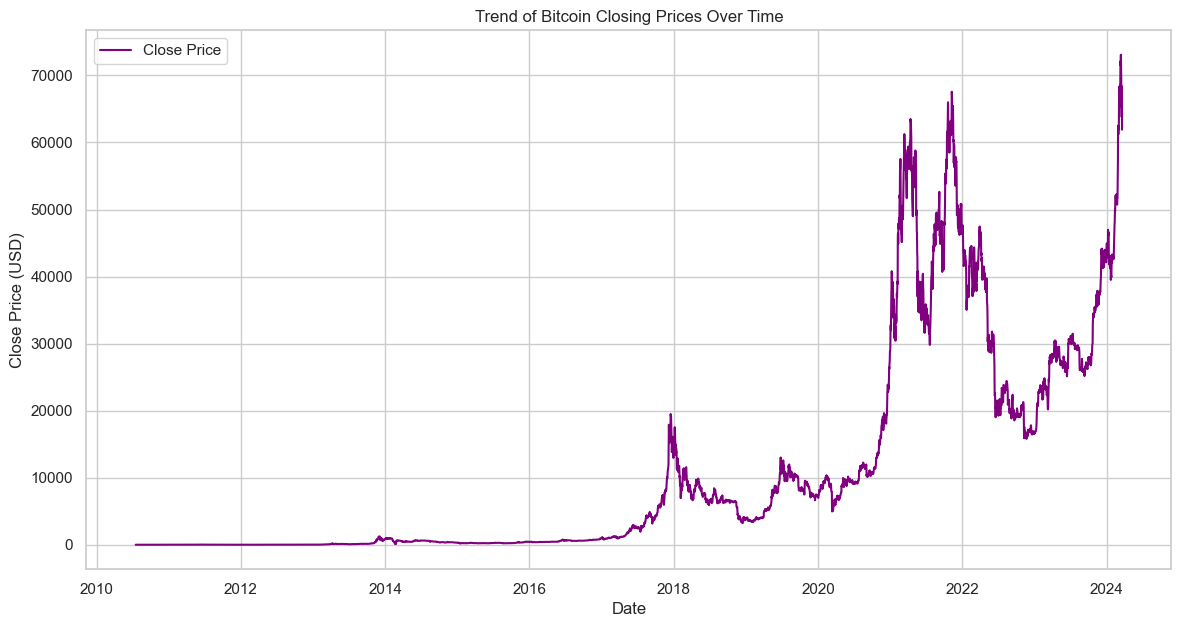

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index of the dataframe
data.set_index('Date', inplace=True)

# Plotting the overall trend of Bitcoin prices using a line chart
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price', color='purple')
plt.title('Trend of Bitcoin Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Xác định các giai đoạn thay đổi 

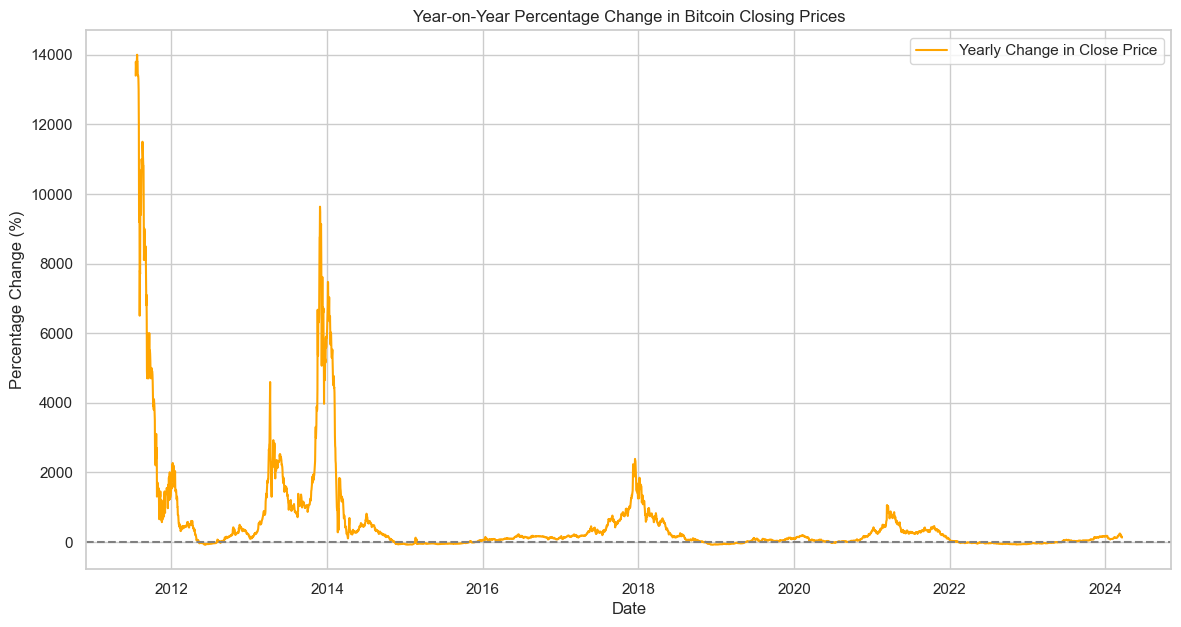

In [5]:
# Identifying significant periods of change
# We will look at the year-on-year percentage change to spot significant movements
data['Yearly Change'] = data['Close'].pct_change(365) * 100  # Calculate the percentage change year-on-year

# Plotting the yearly percentage change
plt.figure(figsize=(14, 7))
plt.plot(data['Yearly Change'], label='Yearly Change in Close Price', color='orange')
plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0% change for reference
plt.title('Year-on-Year Percentage Change in Bitcoin Closing Prices')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid(True)
plt.show()

tính toán biến động hàng ngày(phạm vi giữa giá Cao và Thấp)

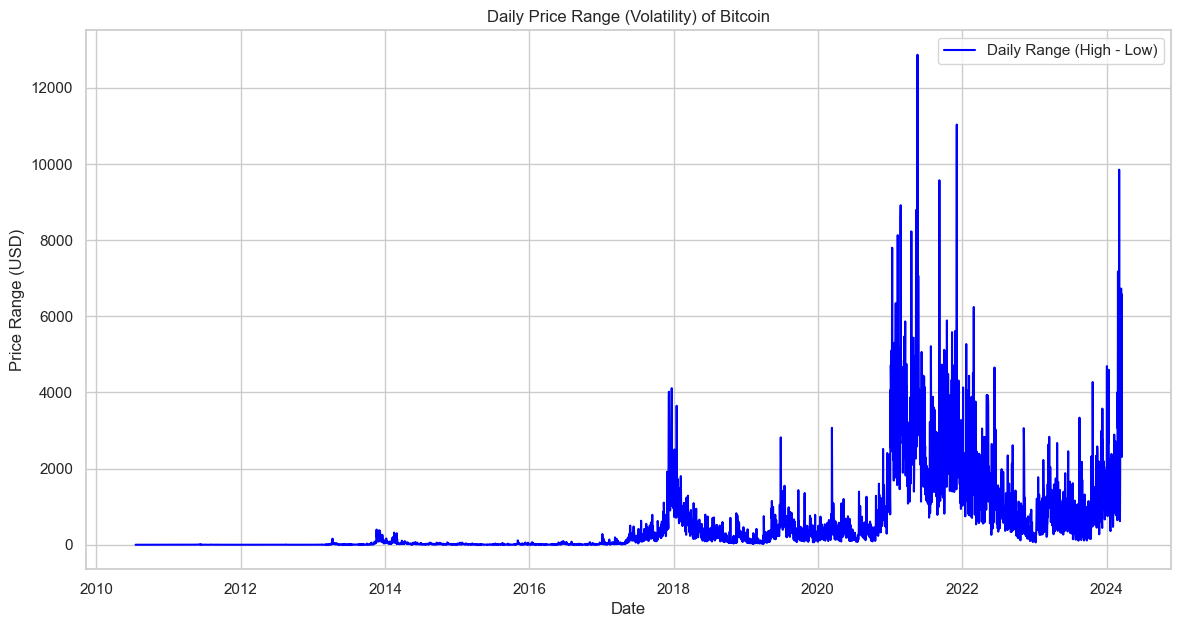

In [6]:
data['Daily Range'] = data['High'] - data['Low']

#Calculate rolling standard deviation for 7-day and 30-day windows
data['Rolling Std 7'] = data['Close'].rolling(window=7).std()
data['Rolling Std 30'] = data['Close'].rolling(window=30).std()

# Plotting the daily range to visualize daily volatility
plt.figure(figsize=(14, 7))
plt.plot(data['Daily Range'], label='Daily Range (High - Low)', color='blue')
plt.title('Daily Price Range (Volatility) of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price Range (USD)')
plt.legend()
plt.grid(True)
plt.show()



Vẽ độ lệch chuẩn lăn để hình dung xu hướng biến động theo thời gian

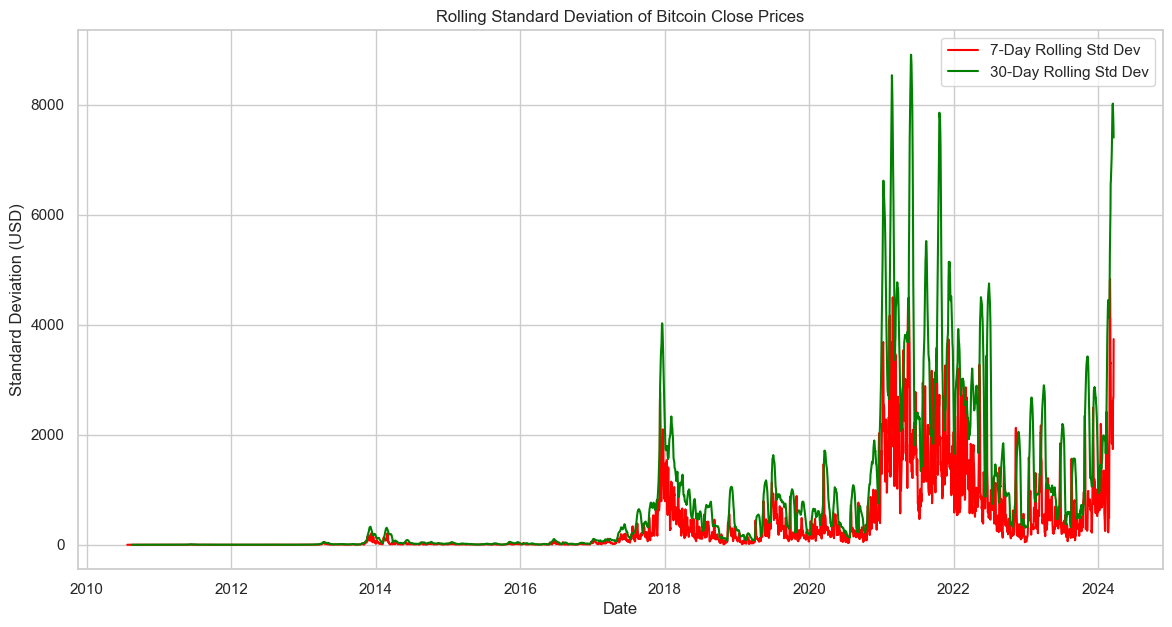

In [7]:
# Plotting rolling standard deviations to visualize trends in volatility over time
plt.figure(figsize=(14, 7))
plt.plot(data['Rolling Std 7'], label='7-Day Rolling Std Dev', color='red')
plt.plot(data['Rolling Std 30'], label='30-Day Rolling Std Dev', color='green')
plt.title('Rolling Standard Deviation of Bitcoin Close Prices')
plt.xlabel('Date')
plt.ylabel('Standard Deviation (USD)')
plt.legend()
plt.grid(True)
plt.show()

biến động theo mùa

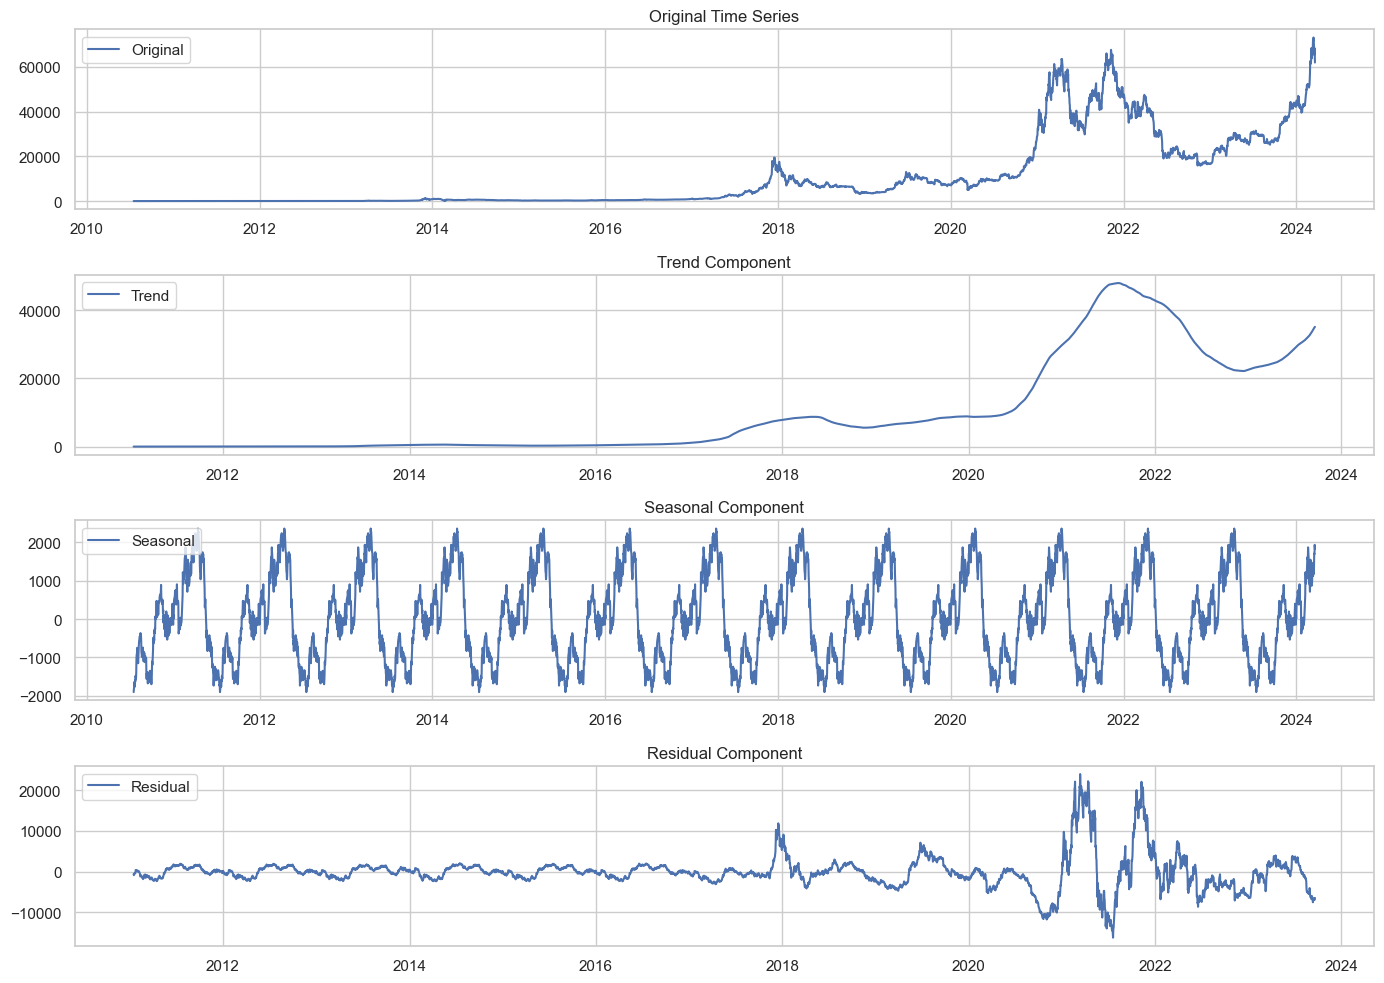

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='additive', period=365)

# Vẽ các thành phần bị phân hủy của chuỗi thời gian 
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

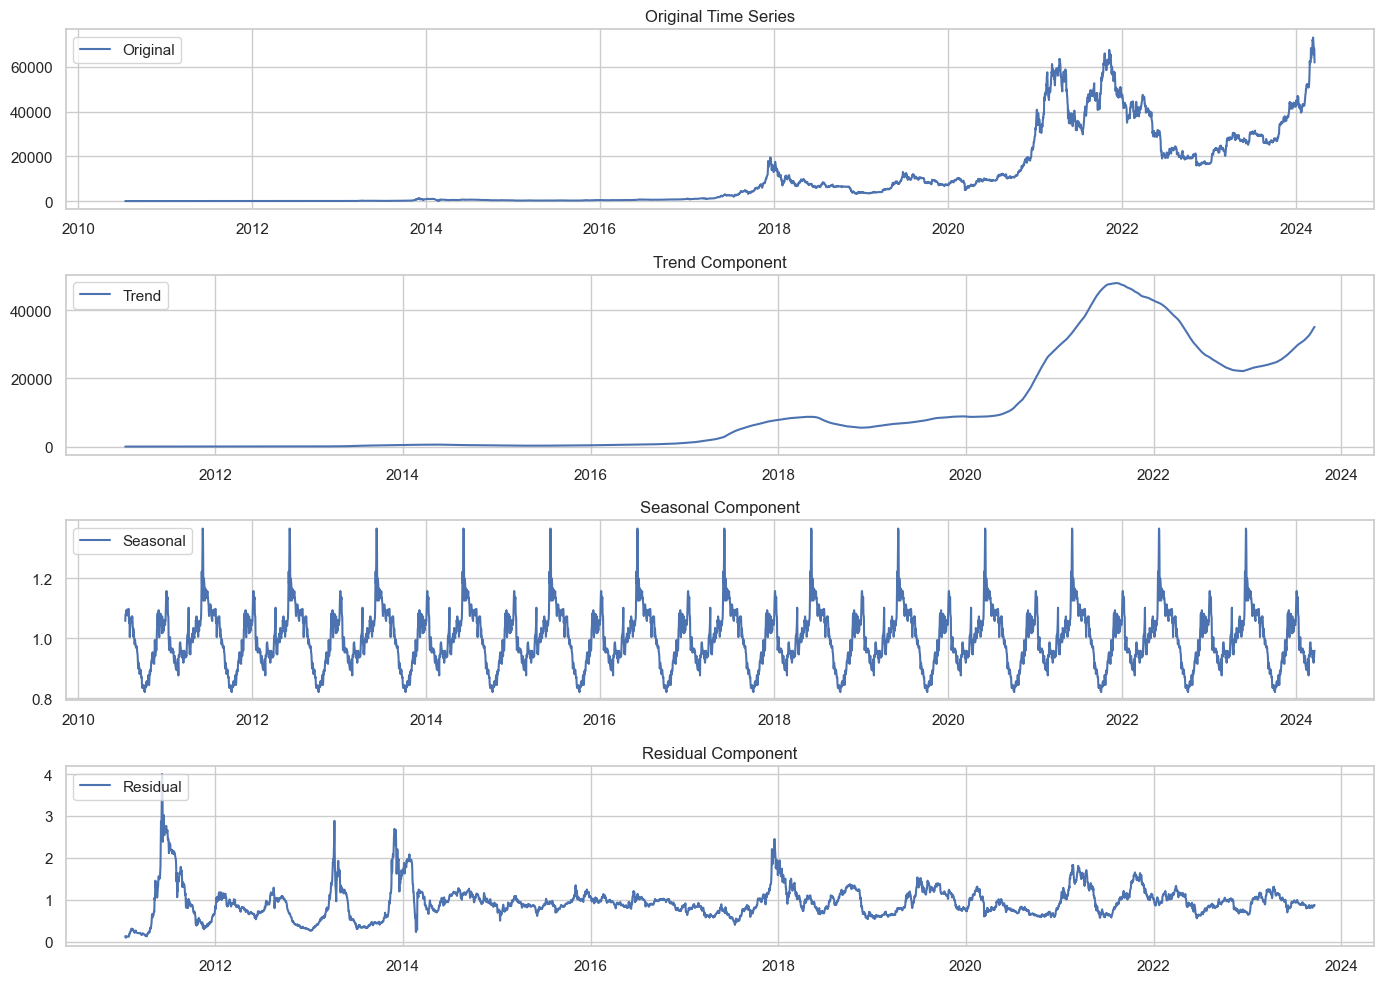

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['Close'], model='multiplicative', period=365)

# Vẽ các thành phần bị phân hủy của chuỗi thời gian 
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(result.observed, label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Mô hình XGBoost 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Prepare the data for modeling
X = data[['Open', 'High', 'Low', 'Volume']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate and print the performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse)

RMSE: 406.186


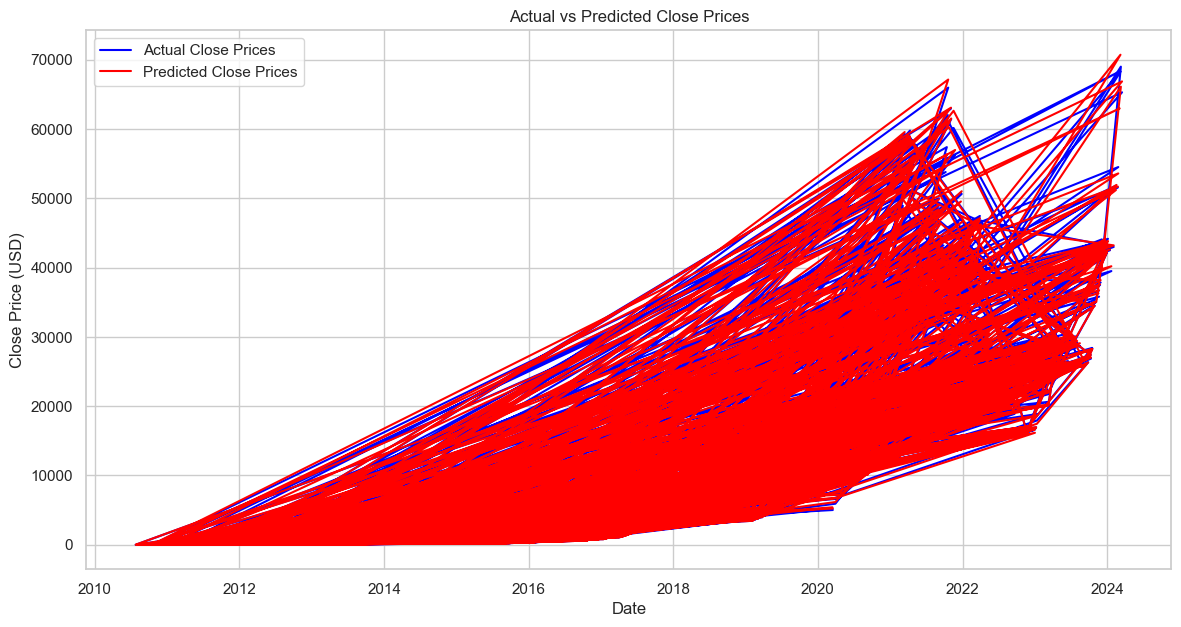

In [11]:
# Plot the actual vs predicted values for better visualization
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Prices', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Close Prices', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

LSTM 

In [12]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout,Flatten
from tensorflow.keras import Sequential
from statsmodels.graphics.tsaplots import plot_acf

In [13]:
price = data.Close
# As usual split data, 70, 30
X = price
size = int(len(X) * 0.7)
train_df, test_df = X[0:size], X[size:len(X)]
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

# Scale the data using minMaxScaler
scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
# assign training values
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [14]:
model = Sequential()
model.add(LSTM(10,input_shape = (None,1), activation="relu", return_sequences=True))
model.add(Dense(1))

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(loss="mean_squared_error",optimizer="adam")
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0416
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0207
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0042
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0012
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2149e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3090e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5997e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4594e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2875e-04
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7734e-04
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2060e-04
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5611e-04
Epoch 15/50
110/110 ━━━━━

In [16]:
# assign test and predicted values + reshaping + converting back from scaler
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))
test_values = scaler.transform(test_values)
test_values = np.reshape(test_values, (len(test_values), 1, 1))
predicted_price = model.predict(test_values)
predicted_price = np.reshape(predicted_price, (len(predicted_price), 1))
predicted_price = scaler.inverse_transform(predicted_price)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


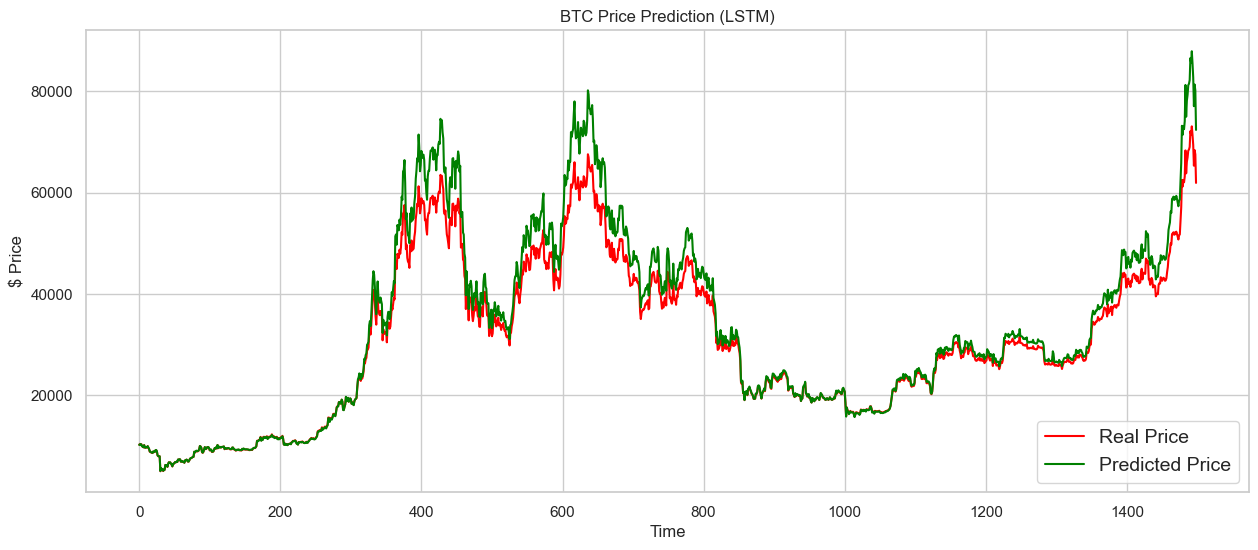

In [17]:
# plotting the results
plt.figure(figsize=(15, 6))
ax = plt.gca()  
plt.plot(test_df.values, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('$ Price')
plt.legend(loc=4, prop={'size': 14})
plt.show()

In [19]:
test_values_flat = np.ravel(test_values)
predicted_price_flat = np.ravel(predicted_price)
rmse = np.sqrt(mean_squared_error(test_values_flat, predicted_price_flat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 37873.119


PROPHET

In [ ]:
from prophet import Prophet
df = data.copy()
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df.columns = ['ds', 'y']
# Next the data is split as usual
X = df
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Initialize and train the XGBoost regressor
models = Prophet()
models.fit(train)

future = models.make_future_dataframe(periods=len(test), freq='D')
forecasting = models.predict(future)
# prediction is stored and RMSE is returned
y_true = test['y'].values
y_pred1 = forecasting.yhat.values[-len(test):]
rmse = np.sqrt(mean_squared_error(y_true, y_pred1))
print('Test RMSE: %.3f' % rmse)

22:40:33 - cmdstanpy - INFO - Chain [1] start processing
22:40:34 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 32892.636


In [ ]:
forecasting.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-07-18,83.319132,-6487.203652,6020.938334,83.319132,83.319132,-709.486477,-709.486477,-709.486477,-12.676208,-12.676208,-12.676208,-696.810269,-696.810269,-696.810269,0.0,0.0,0.0,-626.167345
1,2010-07-19,83.353924,-6889.220848,5805.603486,83.353924,83.353924,-691.535454,-691.535454,-691.535454,0.494677,0.494677,0.494677,-692.030130,-692.030130,-692.030130,0.0,0.0,0.0,-608.181530
2,2010-07-20,83.388715,-6504.594365,5477.729093,83.388715,83.388715,-690.769089,-690.769089,-690.769089,-3.309825,-3.309825,-3.309825,-687.459264,-687.459264,-687.459264,0.0,0.0,0.0,-607.380374
3,2010-07-21,83.423507,-6946.195549,5543.717279,83.423507,83.423507,-682.170193,-682.170193,-682.170193,0.993848,0.993848,0.993848,-683.164041,-683.164041,-683.164041,0.0,0.0,0.0,-598.746687
4,2010-07-22,83.458298,-6843.734607,5275.540877,83.458298,83.458298,-682.225016,-682.225016,-682.225016,-3.040421,-3.040421,-3.040421,-679.184595,-679.184595,-679.184595,0.0,0.0,0.0,-598.766718


c:\Users\T3DCOMPUTER\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\T3DCOMPUTER\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


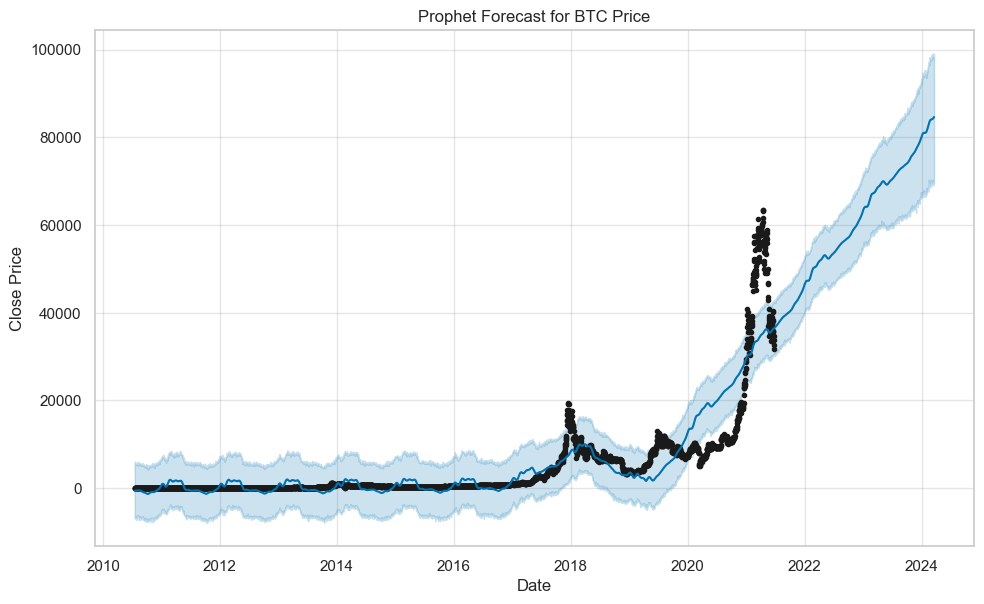

In [ ]:
models.plot(forecasting)
plt.title('Prophet Forecast for BTC Price')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()